In [46]:
from utils.analysis_helpers import * 
from utils.plot_helpers import *
import numpy as np
import pandas as pd
import seaborn as sns
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from matplotlib.ticker import FormatStrFormatter

# I. Training and test performance

In [2]:
N_collection = [20, 40, 80]
V_factors = [1, 2, 4, 8]

performance = {
    'N': [], '|V|': [], 'factor': [], 
    'train_acc': [], 'test_acc': [],   # accuracies
    'train_mae': [], 'test_mae': [],   # mean absolute errors between true and predicted sums
    'random_mae': []                   # mean absolute error for random mapping between input and output sums
}

for N in N_collection:
    
    min_V = 2*N + 1
    
    for factor in V_factors: 
        
        V = min_V * factor
        
        interaction_train = load_interaction(N, V, mode='validation')
        interaction_test = load_interaction(N, V, mode='test')
        
        acc_train, mae_train = calc_performance(interaction_train)
        acc_test, mae_test = calc_performance(interaction_test)
        if factor == 1:
            random_mae = calc_random_mae(interaction_train)
        
        performance['N'].append(N)
        performance['|V|'].append(V)
        performance['factor'].append(factor)
        performance['train_acc'].append(acc_train.item())
        performance['train_mae'].append(mae_train.item())
        performance['test_acc'].append(acc_test.item())
        performance['test_mae'].append(mae_test.item())
        performance['random_mae'].append(random_mae.item())
        
performance = pd.DataFrame(performance)

In [3]:
performance

,N,|V|,factor,train_acc,test_acc,train_mae,test_mae,random_mae
0,20,41,1,0.851385,0.000000,0.931990,3.340909,11.742066
1,20,82,2,0.992443,0.022727,0.105793,1.590909,11.742066
2,20,164,4,1.000000,0.159091,0.000000,1.045455,11.742066
3,20,328,8,0.992443,0.068182,0.105793,1.386364,11.742066
4,40,81,1,0.815598,0.077381,1.537343,3.672619,23.575480
5,40,162,2,0.961005,0.214286,0.345010,2.327381,23.575480
6,40,324,4,0.994052,0.196429,0.031725,2.154762,23.575480
7,40,648,8,0.993391,0.273810,0.113020,2.125000,23.575480
8,80,161,1,0.569179,0.318598,7.223201,8.038110,46.588650
9,80,322,2,0.990178,0.879573,0.341914,0.414634,46.588650


### performance on training and test sets

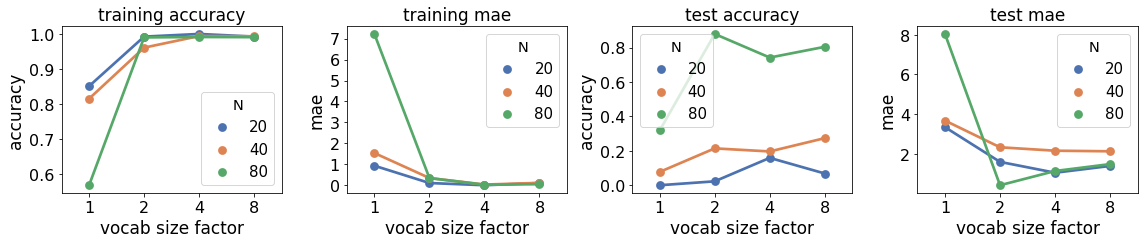

In [4]:
plt.figure(figsize=(16, 3.5))
for i in range(4):
    y = ['train_acc', 'train_mae', 'test_acc', 'test_mae'][i]
    plt.subplot(1, 4, i+1)
    ax = sns.pointplot(x='factor', hue='N', y=y, data=performance, alpha=0.5, palette='deep')
    plt.ylabel(['accuracy', 'mae', 'accuracy', 'mae'][i], fontsize=17)
    plt.xlabel('vocab size factor', fontsize=17)
    plt.title(['training accuracy', 'training mae', 'test accuracy', 'test mae'][i], fontsize=17)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    l = plt.legend(fontsize=15, title='N')
    l.get_title().set_fontsize(fontsize='x-large')
plt.tight_layout()

### performance relative to frequency

In [5]:
N_collection = [20, 40, 80]
V_factors = [2, 4, 8]
results = {
    'V_factor': [], 'N': [], 'sum': [], 
    'frequency': [],                      # frequency of an input sum
    'accuracy': []                        # average accuracy for that input sum
}

for i, N in enumerate(N_collection):
    min_V = 2*N + 1
    
    for j, factor in enumerate(V_factors):
        V = min_V * factor
        
        logs = load_interaction(N, V, mode='train')
        numbers = one_hot_to_numbers(logs.sender_input)
        receiver_output = torch.argmax(logs.receiver_output, dim=1)

        input_sums = torch.sum(numbers, dim=1)
        for sum_i in range(2*N+1):
            indices = torch.where(input_sums == sum_i)[0]
            if len(indices) > 0:
                results['N'].append(N)
                results['V_factor'].append(factor)
                results['sum'].append(sum_i)
                results['frequency'].append(len(indices) / len(input_sums))
                accuracy = torch.mean((input_sums[indices] == receiver_output[indices]).float())
                results['accuracy'].append(accuracy.item())

results = pd.DataFrame(results)

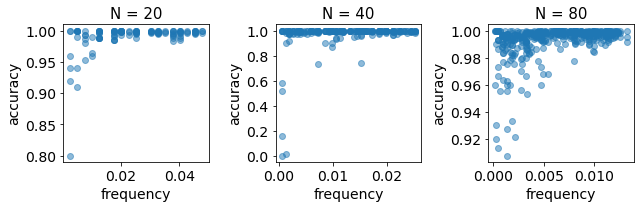

In [6]:
plt.figure(figsize=(9,3))
for i, N in enumerate([20, 40, 80]): 
    
    plt.subplot(1, 3, i+1)
    plt.scatter(results[results.N==N].frequency, results[results.N==N].accuracy, alpha=0.5)
    #plt.show()
    plt.title('N = ' + str(N), fontsize=15)
    plt.xlabel('frequency', fontsize=14)
    plt.ylabel('accuracy', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
plt.tight_layout()

In [10]:
(spearmanr(results.frequency, results.accuracy))

SpearmanrResult(correlation=0.20224776005757766, pvalue=2.9324048906604016e-09)

### performance alternative train/test splits

In [5]:
performance = {
    'split': [],                       # test ratio
    'train_acc': [], 'test_acc': [],   # accuracies
    'train_mae': [], 'test_mae': []    # mean absolute errors between true and predicted sums
}

for split in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8]:
    
    if split != 0.1: 
        name_addition = '_test-split' + str(split)
    else: 
        name_addition = ''
    interaction_train = load_interaction(80, 644, mode='validation', name_addition=name_addition)
    interaction_test = load_interaction(80, 644, mode='test', name_addition=name_addition)
    
    acc_train, mae_train = calc_performance(interaction_train)
    acc_test, mae_test = calc_performance(interaction_test)
    
    performance['split'].append(split)
    performance['train_acc'].append(acc_train.item())
    performance['train_mae'].append(mae_train.item())
    performance['test_acc'].append(acc_test.item())
    performance['test_mae'].append(mae_test.item())

performance = pd.DataFrame(performance)

In [76]:
print(performance)

   split  train_acc  test_acc  train_mae   test_mae
0   0.05   0.991016  0.746951   0.070111   1.475610
1   0.10   0.991363  0.742378   0.024555   1.131098
2   0.20   0.991046  0.224085   0.067632   3.073933
3   0.30   0.991727  0.180894   0.183540   2.900407
4   0.40   0.909830  0.037348   1.234188   4.706174
5   0.50   0.992990  0.030183   0.033526   4.537805
6   0.80   0.992384  0.019245   0.229246  11.228468


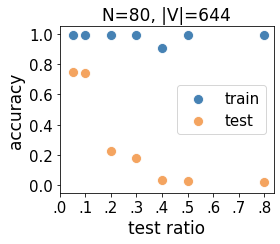

In [84]:
plt.figure(figsize=(4, 3.5))
for i in range(2):
    y = ['train_acc', 'test_acc'][i]
    #ax = plt.plot(performance['split'], performance[y])
    sns.scatterplot(x='split', y=y, data=performance, s=100, color=['steelblue', 'sandybrown'][i])
    plt.ylabel(['accuracy', 'accuracy'][i], fontsize=17)
    plt.xlabel('test ratio', fontsize=17)
    plt.xticks(ticks=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], 
               labels=['.0', '.1', '.2', '.3', '.4', '.5', '.6', '.7', '.8'],
               fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylim([-0.05,1.05])
    plt.title('N=80, |V|=644', fontsize=17)
plt.legend(['train', 'test'], fontsize=15)
plt.tight_layout()

# II. Symbol use 

### number of used symbols

In [7]:
N_collection = [20, 40, 80]
V_factors = [1, 2, 4, 8]

symbol_use = {
    'N': [], '|V|': [], 'factor': [], 
    'absolute_use': [],               # how many distinct symbols are used at least once
    'relative_use': []                # their proportion of the total number of symbols
}

for N in N_collection:
    
    min_V = 2*N + 1
    
    for factor in V_factors: 
        
        V = min_V * factor
        
        logs = load_interaction(N, V, mode='train')
        messages = logs.message.argmax(dim=-1)
        messages = np.ndarray.flatten(messages.numpy())
        distinct = set(messages)
        
        symbol_use['N'].append(N)
        symbol_use['|V|'].append(V)
        symbol_use['factor'].append(factor)
        symbol_use['absolute_use'].append(len(distinct))
        symbol_use['relative_use'].append(len(distinct) / V)
        
symbol_use = pd.DataFrame(symbol_use)

In [8]:
symbol_use

,N,|V|,factor,absolute_use,relative_use
0,20,41,1,39,0.951220
1,20,82,2,58,0.707317
2,20,164,4,86,0.524390
3,20,328,8,149,0.454268
4,40,81,1,79,0.975309
5,40,162,2,114,0.703704
6,40,324,4,132,0.407407
7,40,648,8,383,0.591049
8,80,161,1,144,0.894410
9,80,322,2,190,0.590062


### mapping between symbols and sums / input pairs 

In [3]:
N_collection = [20, 40, 80]
V_factors = [1, 2, 4, 8]

mappings = {'N': [], '|V|': [], 'factor': [], 
            'input_type': [],                   # sum or summands
            'synonymy_mean': [],                # average #symbols/input
            'polysemy_mean': [],                # average #inputs/symbols
            'synonymy': [],                     # dict with all symbols per input
            'polysemy': [],                     # dict with all inputs per symbol
            'synonymy_frequency': [],           # dict with all co-occurrence counts for mappings in synonymy
            'polysemy_frequency': [],           # dict with co-occurrence counts for mappings in polysemy
            'polysemy': [],                     # dict with all inputs per symbol
            'NMI': [],                          # normalized mutual information (messages, input)
            'H(m|input)': [],                   # normalized conditional entropy of messages given inputs
            'H(input|m)': []}                   # normalized conditional entropy of inputs given messages

for N in N_collection:
    print('loading results for N: ', N)
    
    min_V = 2*N + 1
    
    for factor in V_factors:
        
        V = min_V * factor
        
        logs = load_interaction(N, V, mode='train')
        numbers = one_hot_to_numbers(logs.sender_input)
        sums = torch.sum(numbers, dim=1)
        messages = logs.message.argmax(dim=-1)
        
        synonymy_summands, synonymy_summands_mean, synonymy_summands_f = synonymy_dict(numbers, messages)
        synonymy_sum, synonymy_sum_mean, synonymy_sum_f = synonymy_dict(sums, messages)
        polysemy_summands, polysemy_summands_mean, polysemy_summands_f = polysemy_dict(numbers, messages)
        polysemy_sum, polysemy_sum_mean, polysemy_sum_f = polysemy_dict(sums, messages)
        information_metrics = information_scores(logs)
        
        for input_type in ['sum', 'summands']:
            
            mappings['N'].append(N)
            mappings['|V|'].append(V)
            mappings['factor'].append(factor)
            mappings['input_type'].append(input_type)
            
            if input_type == 'sum':
                mappings['synonymy'].append(synonymy_sum)
                mappings['synonymy_mean'].append(synonymy_sum_mean)
                mappings['synonymy_frequency'].append(synonymy_sum_f)
                mappings['polysemy'].append(polysemy_sum)
                mappings['polysemy_mean'].append(polysemy_sum_mean)
                mappings['polysemy_frequency'].append(polysemy_sum_f)
                mappings['NMI'].append(information_metrics['NMI_sum'])
                mappings['H(m|input)'].append(information_metrics['synonymy_sum'])
                mappings['H(input|m)'].append(information_metrics['polysemy_sum'])
                
            elif input_type == 'summands':
                mappings['synonymy'].append(synonymy_summands)
                mappings['synonymy_mean'].append(synonymy_summands_mean)
                mappings['synonymy_frequency'].append(synonymy_summands_f)
                mappings['polysemy'].append(polysemy_summands)
                mappings['polysemy_mean'].append(polysemy_summands_mean)
                mappings['polysemy_frequency'].append(polysemy_summands_f)
                mappings['NMI'].append(information_metrics['NMI_summands'])
                mappings['H(m|input)'].append(information_metrics['synonymy_summands'])
                mappings['H(input|m)'].append(information_metrics['polysemy_summands'])

mappings = pd.DataFrame(mappings)

loading results for N:  20
loading results for N:  40
loading results for N:  80


In [4]:
mappings_subset = mappings.loc[:, (mappings.columns!='polysemy') & (mappings.columns!='synonymy') &
                                  (mappings.columns!='polysemy_frequency') & (mappings.columns!='synonymy_frequency')] 

In [11]:
# input type summands

mappings_subset[mappings.input_type=='summands']

,N,|V|,factor,input_type,synonymy_mean,polysemy_mean,NMI,H(m|input),H(input|m)
1,20,41,1,summands,1.267003,12.897436,0.720109,0.031817,0.426769
3,20,82,2,summands,1.259446,8.620690,0.752389,0.018093,0.390159
5,20,164,4,summands,2.224181,10.267442,0.720430,0.080089,0.407955
7,20,328,8,summands,2.952141,7.865772,0.720847,0.109445,0.394533
9,40,81,1,summands,1.313285,25.151899,0.703691,0.033764,0.446661
11,40,162,2,summands,1.107733,14.701754,0.740970,0.008198,0.408598
13,40,324,4,summands,1.190350,13.643939,0.747005,0.013784,0.398815
15,40,648,8,summands,3.296761,13.023499,0.711961,0.112861,0.405443
17,80,161,1,summands,1.655885,67.902778,0.645671,0.068062,0.506055
19,80,322,2,summands,1.128704,35.078947,0.719445,0.009930,0.434993


In [12]:
# input type sums

mappings_subset[mappings.input_type=='sum']

,N,|V|,factor,input_type,synonymy_mean,polysemy_mean,NMI,H(m|input),H(input|m)
0,20,41,1,sum,1.804878,1.897436,0.918140,0.082195,0.081524
2,20,82,2,sum,2.073171,1.465517,0.967456,0.055475,0.008472
4,20,164,4,sum,4.121951,1.965116,0.935185,0.102561,0.023754
6,20,328,8,sum,7.268293,2.000000,0.906208,0.152599,0.026215
8,40,81,1,sum,2.876543,2.949367,0.892906,0.105985,0.108202
10,40,162,2,sum,2.135802,1.517544,0.957035,0.060774,0.024468
12,40,324,4,sum,2.172840,1.333333,0.960533,0.067429,0.009778
14,40,648,8,sum,9.641975,2.039164,0.904216,0.160611,0.020106
16,80,161,1,sum,3.656250,4.062500,0.840521,0.133098,0.184301
18,80,322,2,sum,2.050000,1.726316,0.985236,0.021138,0.008306


#### synonymy polysemy - conditional entropy analysis

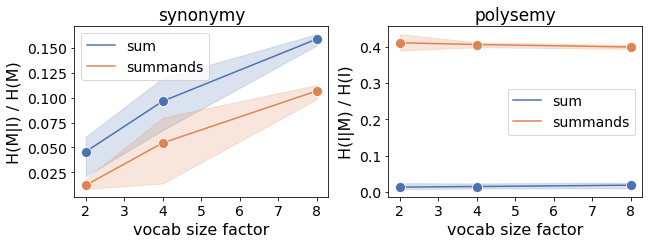

In [19]:
plt.figure(figsize=(9, 3.5))

for i in range(2): 
    plt.subplot(1, 2, i+1)
    metric = ['H(m|input)', 'H(input|m)'][i]
    ax = sns.lineplot(x='factor', hue='input_type', ci=100, y=metric, data=mappings[mappings.factor > 1], palette='deep', 
                      marker="o", markersize=10)
    #ax = sns.pointplot(x='factor', hue='input_type', ci=None, y=metric, data=test, palette='deep')
    plt.title(['synonymy', 'polysemy'][i], fontsize=17)
    plt.ylabel(['H(M|I) / H(M)', 'H(I|M) / H(I)'][i], fontsize=16)
    plt.xlabel('vocab size factor', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    l = plt.legend(fontsize=14)
    l.set_title(None)
plt.tight_layout()

#### evaluating the systematicity of polysemy and synonymy based on input sums

In [4]:
mappings_sum = mappings[mappings.input_type == 'sum']

consistent_symbol_use = []         
consistent_input_description = [] 
consistent_symbol_use_subset = []         
consistent_input_description_subset = []  

for N in [20, 40, 80]:
    for factor in [2, 4, 8]:

        synonymy_frequency = mappings_sum.synonymy_frequency[(mappings.N==N) & (mappings.factor == factor)]
        polysemy_frequency = mappings_sum.polysemy_frequency[(mappings.N==N) & (mappings.factor == factor)]
        synonymy_frequency = synonymy_frequency[synonymy_frequency.keys()[0]]
        polysemy_frequency = polysemy_frequency[polysemy_frequency.keys()[0]]
        
        local_symbol_consistency = []
        local_input_consistency = []
        local_symbol_consistency_subset = []
        local_input_consistency_subset = []
        for key in synonymy_frequency.keys(): 
            local_input_consistency.append(max(synonymy_frequency[key]) / sum(synonymy_frequency[key]))
            if len(synonymy_frequency[key]) > 1: 
                local_input_consistency_subset.append(max(synonymy_frequency[key]) / sum(synonymy_frequency[key]))
        for key in polysemy_frequency.keys():
            local_symbol_consistency.append(max(polysemy_frequency[key]) / sum(polysemy_frequency[key]))
            if len(polysemy_frequency[key]) > 1: 
                local_symbol_consistency_subset.append(max(polysemy_frequency[key]) / sum(polysemy_frequency[key]))
        
        consistent_symbol_use.append(np.mean(local_symbol_consistency))
        consistent_input_description.append(np.mean(local_input_consistency))
        consistent_symbol_use_subset.append(np.mean(local_symbol_consistency_subset))
        consistent_input_description_subset.append(np.mean(local_input_consistency_subset))

In [57]:
count = 0
for N in [20, 40, 80]:
    for factor in [2, 4, 8]: 
        print('N:', N, ', factor:', factor, 
              'value:', round(consistent_input_description[count], 3),
              'value subset', round(consistent_input_description_subset[count], 3)
             )
        count += 1

N: 20 , factor: 2 value: 0.922 value subset 0.89
N: 20 , factor: 4 value: 0.89 value subset 0.868
N: 20 , factor: 8 value: 0.78 value subset 0.769
N: 40 , factor: 2 value: 0.917 value subset 0.844
N: 40 , factor: 4 value: 0.907 value subset 0.856
N: 40 , factor: 8 value: 0.735 value subset 0.721
N: 80 , factor: 2 value: 0.945 value subset 0.916
N: 80 , factor: 4 value: 0.792 value subset 0.775
N: 80 , factor: 8 value: 0.674 value subset 0.672


In [70]:
print(np.mean([consistent_input_description[i] for i in [0, 3, 6]]))
print(np.mean([consistent_input_description[i] for i in [1, 4, 7]]))
print(np.mean([consistent_input_description[i] for i in [2, 5, 8]]))

0.928196832901062
0.8630825714429351
0.7295895173079429


In [58]:
count = 0
for N in [20, 40, 80]:
    for factor in [2, 4, 8]: 
        print('N:', N, ', factor:', factor, 
              'value:', round(consistent_symbol_use[count], 3),
              'value subset', round(consistent_symbol_use_subset[count], 3)
             )
        count += 1

N: 20 , factor: 2 value: 0.967 value subset 0.917
N: 20 , factor: 4 value: 0.934 value subset 0.884
N: 20 , factor: 8 value: 0.931 value subset 0.884
N: 40 , factor: 2 value: 0.95 value subset 0.868
N: 40 , factor: 4 value: 0.991 value subset 0.966
N: 40 , factor: 8 value: 0.937 value subset 0.899
N: 80 , factor: 2 value: 0.971 value subset 0.944
N: 80 , factor: 4 value: 0.958 value subset 0.935
N: 80 , factor: 8 value: 0.932 value subset 0.894


In [71]:
np.mean(consistent_input_description)

0.8402896405506467

#### synonymy, polysemy - co-occurrence analysis (appendix)

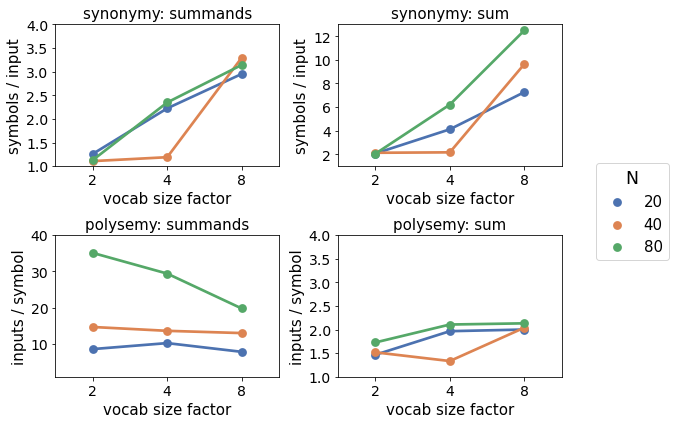

In [62]:
fig = plt.figure(figsize=(8, 6))

for i in range(4): 
    plt.subplot(2, 2, i+1)
    metric = ['synonymy_mean', 'synonymy_mean', 'polysemy_mean', 'polysemy_mean'][i]
    input_type = ['summands', 'sum', 'summands', 'sum']
    ax = sns.pointplot(x='factor', y=metric, hue='N',
                       data=mappings[(mappings.input_type==input_type[i]) & (mappings.factor > 1)], 
                       palette='deep')
    plt.title(['synonymy', 'synonymy', 'polysemy', 'polysemy'][i] +': ' + input_type[i] , fontsize=15)
    plt.ylabel(['symbols / input', 'symbols / input', 'inputs / symbol', 'inputs / symbol'][i], fontsize=15)
    plt.xlabel('vocab size factor', fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylim([[1,4], [1,13], [1,40], [1,4]][i])
    #l = plt.legend(fontsize=13, title='N')
    #l.get_title().set_fontsize(fontsize='x-large')
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()

l = fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.18,0.5), fontsize=15, title='N')
l.get_title().set_fontsize(fontsize='xx-large')
    
plt.tight_layout()

### example run (appendix)

In [72]:
example_run = mappings[(mappings.N==20) & (mappings.factor==2) & (mappings.input_type=='sum')]

key = example_run.synonymy.keys()[0]
synonymy = dict(example_run.synonymy)[key]
polysemy = dict(example_run.polysemy)[key]

synonymy_df, polysemy_df = get_synonymy_polysemy_dfs(synonymy, polysemy)

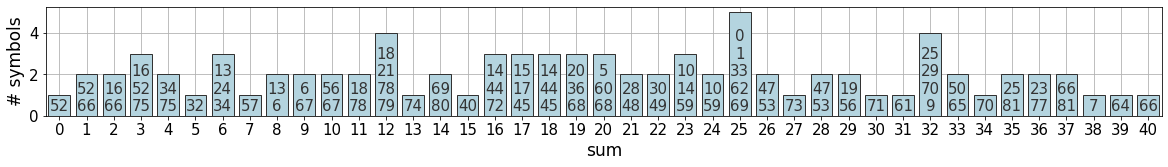

In [73]:
plt.figure(figsize=(20,2))
ax = sns.barplot(x='x', y='y', data=synonymy_df, color='lightblue', edgecolor="0.2")
labels = symbols_to_plot_labels(synonymy)
plt.grid()
for i in range(41):
    ax.text(i, len(synonymy[str(i)])-(0.6 + len(synonymy[str(i)])*1), labels[i], color='0.2', ha="center",
            fontsize=15)
plt.xlabel('sum', fontsize=17)
plt.ylabel('# symbols', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_axisbelow(True)
plt.show()

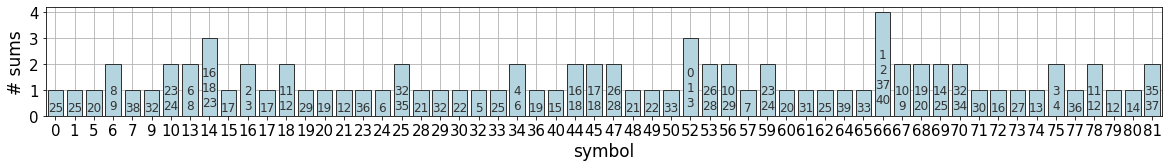

In [74]:
plt.figure(figsize=(20,2))
ax = sns.barplot(x='x', y='y', data=polysemy_df, color='lightblue', edgecolor="0.2")
plt.grid()
labels, symbols = sums_to_plot_labels(polysemy)
for i, s in enumerate(symbols):
    ax.text(i, len(polysemy[str(s)])-(0.5 + len(polysemy[str(s)])*0.9), labels[i], color='0.2', ha="center",
            fontsize=12)
plt.xlabel('symbol', fontsize=17)
plt.ylabel('# sums', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_axisbelow(True)
plt.show()